### Controlled Class Ratios on Augmented Data 

#### Overview
Training and evaluation of the model using 1:5 ratio of definitional to non-definitional sentences using the MPNet embedding model (`paraphrase-mpnet-base-v2`)

/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-1-93b22bf0cb6f>:54: DeprecationWarning: `SetFit

Starting training with a 1:5 ratio of definitional to non-definitional sentences...

Epoch 1/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.340100
50,0.349600
100,0.309200
150,0.269100
200,0.243700
250,0.207800
300,0.171600
350,0.146400
400,0.128800
450,0.127200


Validation Metrics after Epoch 1:
  AUC-ROC: 0.9184
  Precision: 0.9276
  Recall: 0.8514
  F1-Score: 0.8879
  F2-Score: 0.8656
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/train_model_epoch_1

Epoch 2/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000000
50,0.006300
100,0.006200
150,0.004500
200,0.005500
250,0.003000
300,0.007100
350,0.003600
400,0.007000
450,0.006700


Validation Metrics after Epoch 2:
  AUC-ROC: 0.9193
  Precision: 0.9316
  Recall: 0.8524
  F1-Score: 0.8903
  F2-Score: 0.8671
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/train_model_epoch_2

Epoch 3/3


***** Running training *****
  Num unique pairs = 909040
  Batch size = 16
  Num epochs = 1


Step,Training Loss
1,0.000000
50,0.004200
100,0.006200
150,0.003200
200,0.003600
250,0.002500
300,0.005400
350,0.002700
400,0.006300
450,0.005300


Validation Metrics after Epoch 3:
  AUC-ROC: 0.9204
  Precision: 0.9328
  Recall: 0.8543
  F1-Score: 0.8918
  F2-Score: 0.8690
Model saved at: /home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/train_model_epoch_3


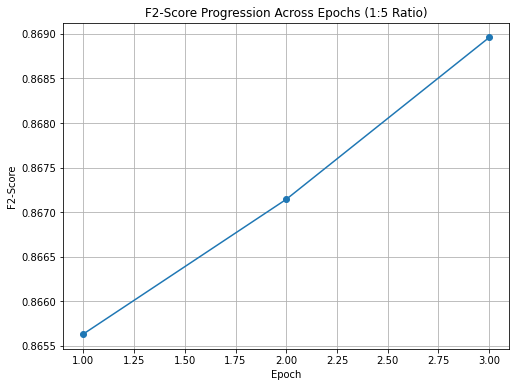

F2-Score progression chart saved at: /home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/f2_scores_progression.png
Final model saved at: /home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/final_trained_model

Test Set Metrics (Final Evaluation):
AUC-ROC: 0.9248
Precision: 0.9232
Recall: 0.8654
F1-Score: 0.8934
F2-Score: 0.8764


In [1]:
import os
import pandas as pd
from sklearn.utils import shuffle
from datasets import Dataset
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

train_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/train_split_augmented.csv'
val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_augmented.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'

train_data = pd.read_csv(train_split_path)
val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

# Separating sentences
def_data = train_data[train_data['definition_sentence'] == 1]
non_def_data = train_data[train_data['definition_sentence'] == 0]

# 1:5 ratio of definitions to non-definitions
num_definitions = len(def_data)
num_required_non_definitions = num_definitions * 5

# Randomly sampling
sampled_non_definitions = non_def_data.sample(
    n=min(num_required_non_definitions, len(non_def_data)), 
    random_state=42 
)

# Combining sentences
balanced_train_data = pd.concat([def_data, sampled_non_definitions])

# Shuffling data for randomization
balanced_train_data = shuffle(balanced_train_data, random_state=42)

train_dataset = Dataset.from_pandas(balanced_train_data)
val_dataset = Dataset.from_pandas(val_data)

epoch_save_dir = "/home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio"
os.makedirs(epoch_save_dir, exist_ok=True)

model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2")
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    loss_class=CosineSimilarityLoss,
    batch_size=16,
    num_iterations=20,
    column_mapping={"sentence_original": "text", "definition_sentence": "label"}
)
f2_scores = []

num_epochs = 3 
print("Starting training with a 1:5 ratio of definitional to non-definitional sentences...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train() 

    # Evaluation of validation set
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = trainer.model.predict(val_data['sentence_original'].tolist())
    
    f2 = fbeta_score(val_labels, val_predictions, beta=2)
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')

    print(f"Validation Metrics after Epoch {epoch + 1}:")
    print(f"  AUC-ROC: {val_auc:.4f}")
    print(f"  Precision: {val_precision:.4f}")
    print(f"  Recall: {val_recall:.4f}")
    print(f"  F1-Score: {val_f1:.4f}")
    print(f"  F2-Score: {f2:.4f}")
    
    f2_scores.append(f2)

    model_save_path_epoch = os.path.join(epoch_save_dir, f"train_model_epoch_{epoch + 1}")
    model.save_pretrained(model_save_path_epoch)
    print(f"Model saved at: {model_save_path_epoch}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(f2_scores) + 1), f2_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("F2-Score")
plt.title("F2-Score Progression Across Epochs (1:5 Ratio)")
plt.grid(True)
progress_chart_path = os.path.join(epoch_save_dir, "f2_scores_progression.png")
plt.savefig(progress_chart_path)
plt.show()
print(f"F2-Score progression chart saved at: {progress_chart_path}")

final_model_path = os.path.join(epoch_save_dir, "final_trained_model")
model.save_pretrained(final_model_path)
print(f"Final model saved at: {final_model_path}")

# Evaluate on the test set
test_labels = test_data['definition_sentence'].tolist()
test_predictions = model.predict(test_data['sentence_original'].tolist())

# metrics calculation
test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

print("\nTest Set Metrics (Final Evaluation):")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### Graphs and Performance Visualization

In [1]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score
from datasets import Dataset
from setfit import SetFitModel

val_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/val_split_augmented.csv'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
model_dir = '/home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/'

val_data = pd.read_csv(val_split_path)
test_data = pd.read_csv(test_split_path)

epoch_metrics = []
num_epochs = 3

for epoch in range(1, num_epochs + 1):
    model_path = os.path.join(model_dir, f"train_model_epoch_{epoch}")
    model = SetFitModel.from_pretrained(model_path)
    
    val_labels = val_data['definition_sentence'].tolist()
    val_predictions = model.predict(val_data['sentence_original'].tolist())
    
    val_auc = roc_auc_score(val_labels, val_predictions)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(val_labels, val_predictions, average='binary')
    val_f2 = fbeta_score(val_labels, val_predictions, beta=2)
    
    epoch_metrics.append({
        "Epoch": epoch,
        "AUC-ROC": val_auc,
        "Precision": val_precision,
        "Recall": val_recall,
        "F1-Score": val_f1,
        "F2-Score": val_f2
    })

final_model_path = os.path.join(model_dir, "final_trained_model")
final_model = SetFitModel.from_pretrained(final_model_path)
test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

epoch_metrics.append({
    "Epoch": "Test Split",
    "AUC-ROC": test_auc,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1-Score": test_f1,
    "F2-Score": test_f2
})

metrics_df = pd.DataFrame(epoch_metrics)
print(metrics_df)


/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


        Epoch   AUC-ROC  Precision    Recall  F1-Score  F2-Score
0           1  0.918409   0.927583  0.851417  0.887870  0.865633
1           2  0.919328   0.931624  0.852395  0.890250  0.867144
2           3  0.920412   0.932764  0.854350  0.891837  0.868960
3  Test Split  0.924808   0.923205  0.865415  0.893376  0.876387


/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


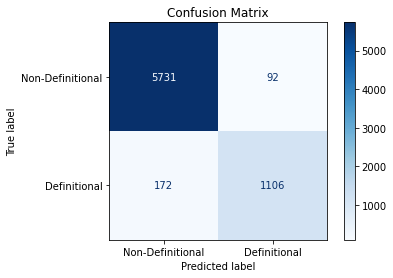


Final Model - Test Set Metrics:
AUC-ROC: 0.9248
Precision: 0.9232
Recall: 0.8654
F1-Score: 0.8934
F2-Score: 0.8764


: 

In [ ]:
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
from setfit import SetFitModel
import matplotlib.pyplot as plt

test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'
final_model_path = '/home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/final_trained_model'

test_data = pd.read_csv(test_split_path)
final_model = SetFitModel.from_pretrained(final_model_path)

test_labels = test_data['definition_sentence'].tolist()
test_predictions = final_model.predict(test_data['sentence_original'].tolist())

test_auc = roc_auc_score(test_labels, test_predictions)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_predictions, average='binary')
test_f2 = fbeta_score(test_labels, test_predictions, beta=2)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Definitional", "Definitional"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("\nFinal Model - Test Set Metrics:")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"F2-Score: {test_f2:.4f}")


#### ROC Curve and AUC-ROC Evaluation

/home/roland/Projects/saras_folder/myvenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


AUC-ROC: 0.9383


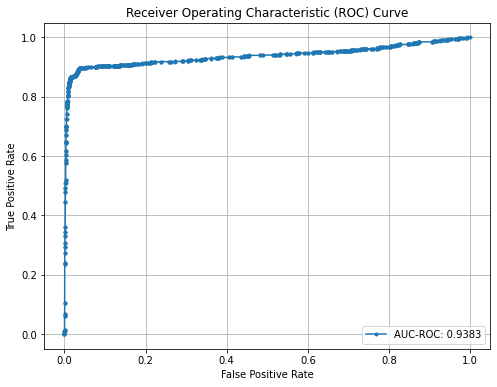

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from setfit import SetFitModel

model_path = '/home/roland/Projects/saras_folder/Data_Splitting/1-5-ratio/final_trained_model'
test_split_path = '/home/roland/Projects/saras_folder/Data_Splitting/test_split_augmented.csv'

test_data = pd.read_csv(test_split_path)

model = SetFitModel.from_pretrained(model_path)
test_labels = test_data['definition_sentence'].tolist()
test_sentences = test_data['sentence_original'].tolist()
#Probabilities for the test set
probabilities = model.predict_proba(test_sentences)
# Extract probabilities for definitional sentences
positive_probabilities = probabilities[:, 1]

test_auc = roc_auc_score(test_labels, positive_probabilities)
print(f"AUC-ROC: {test_auc:.4f}")
# Computation the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, positive_probabilities)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC: {test_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()